In [2]:

import numpy as np
import astropy.units as u
import astropy.io.fits as fits
import matplotlib.pyplot as plt

import poppy

from gmagaox.imshows import *

from gmagaox.math_module import xp, ensure_np_array

wavelength = 633*u.nm
diam = 25.4*u.mm
npix = 2540

pxscl = diam/npix
max_sf = 1/pxscl/2

wf = poppy.FresnelWavefront(beam_radius=diam/2, npix=npix, oversample=1)

def psd_model(k, psd_parm):
    # k: array/matrix of spatial frequencies
    # psd_parm: list with the PSD parameters
    alpha = psd_parm[0]
    beta = psd_parm[1]
    oscl = psd_parm[2]
    iscl = psd_parm[3]
    bsr = psd_parm[4]
    if oscl.value != 0:
        denom = ( ((1/oscl)**2) + (k**2))**(alpha/2)
    else: # explosion prevention
        denom = (k**2)**(alpha/2)
    pk = ((beta/denom) * np.exp(-((k.value*iscl)**2))) + bsr
    return pk





Oversampling > 2x suggested for reliable results in Fresnel propagation.


In [45]:
psd_params['beta'].decompose().unit

Unit("m(6/5)")

In [34]:
u.m**2/(u.m**(3.029-2))

Unit("m(0.9710000000000001)")

In [62]:
alpha = 3.029
dk = 1/(screen_size * u.m/u.pix * u.pix)
beta = 329.3 * u.m**2/(u.m**(alpha-2))
display(beta)
psd_units = (beta.unit / ((dk.unit**2)**(alpha/2)))
display(psd_units)

<Quantity 329.3 m(0.9710000000000001)>

Unit("m4")

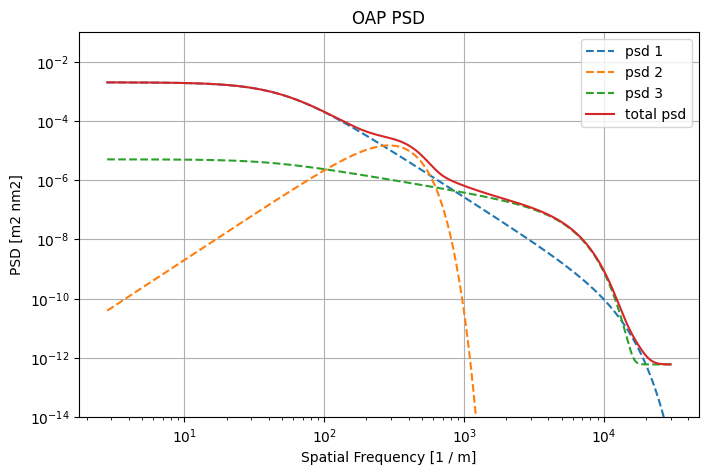

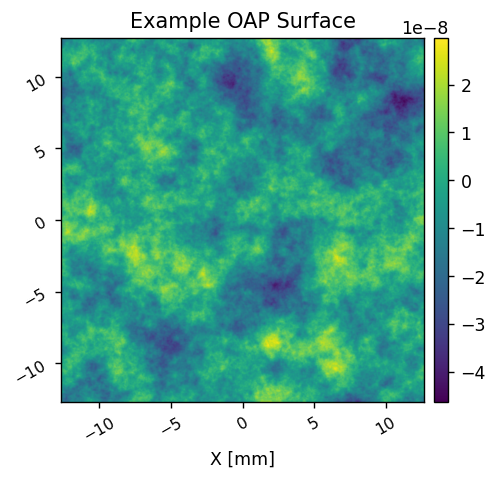

In [12]:
# alpha = 2.8

# surface_unit = u.nm
# length_unit = u.m

# psd_params = {
#     'alpha':alpha,
#     'beta':0.637*u.nm**2 / (u.m**(alpha-2)),
#     'outer_scale':0.1*u.m,
#     'inner_scale':1e-4,
#     'surf_roughness':1e-9 * u.m**2 * u.nm**2,
# }
# psd_list = [[psd_params['alpha'], psd_params['beta'],
#              psd_params['outer_scale'], psd_params['inner_scale'], psd_params['surf_roughness']]]

psd_list = [[3.029, 329.3* u.nm**2/(u.m**(3.029-2)), 0.019*u.m, 0.0001, 0 * u.nm**2 * u.m**2],
            [-3.103, 1.606e-12*u.nm**2/(u.m**(-3.103-2)), 16*u.m, 0.00429,0*u.nm**2 * u.m**2],
            [0.8, 0.0001*u.nm**2/(u.m**(0.8-2)), 0.024*u.m, 0.00021, 6.01284e-13*u.nm**2 * u.m**2]]

seed = 123456

params = {
    'psd_parameters': psd_list, 
    'psd_weight': [1],
    'apply_reflection':True, 
    # 'incident_angle':15*u.degree, 
    'screen_size':int(npix*1), 
}

k_range = (np.arange(start=2.8, stop=30000, step=0.95)/u.m)
psd1 = psd_model(k_range, psd_list[0])
psd2 = psd_model(k_range, psd_list[1])
psd3 = psd_model(k_range, psd_list[2])

psd_tot = psd1 + psd2 + psd3

fig = plt.figure(figsize=[8,5], dpi=100)
plt.loglog(k_range.value, psd1.value, '--', label='psd 1',)
plt.loglog(k_range.value, psd2.value, '--', label='psd 2')
plt.loglog(k_range.value, psd3.value, '--', label='psd 3')
plt.loglog(k_range.value, psd_tot.value, label='total psd', linewidth=1.5)

# plt.vlines(max_sf.to_value(1/u.m), 1e-11, 1e-1, color='red')
plt.grid()
plt.ylim(top=0.1, bottom=1e-14)
plt.xlabel('Spatial Frequency [{0}]'.format(k_range.unit))
plt.ylabel('PSD [{0}]'.format(psd1.unit))
plt.title('OAP PSD')
plt.legend()
plt.close()
display(fig)

wfe = poppy.PowerSpectrumWFE(**params, incident_angle=15*u.degree, seed=12, )

psd_opd = wfe.get_opd(wf)

imshow1(psd_opd, 'Example OAP Surface', pxscl=wf.pixelscale.to(u.mm/u.pix), xlabel='X [mm]', cmap='viridis')

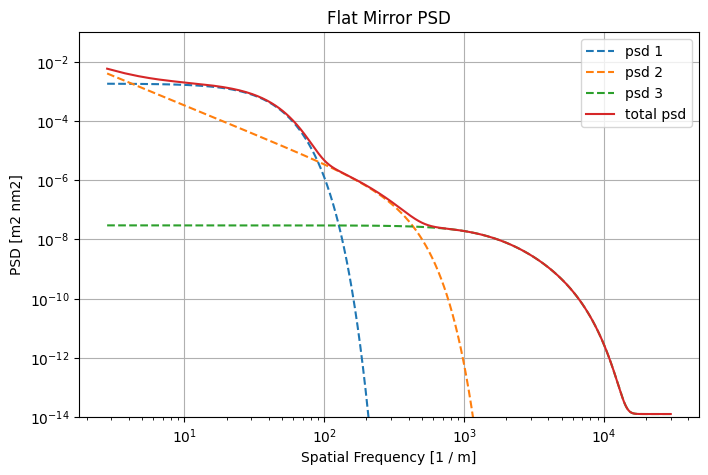

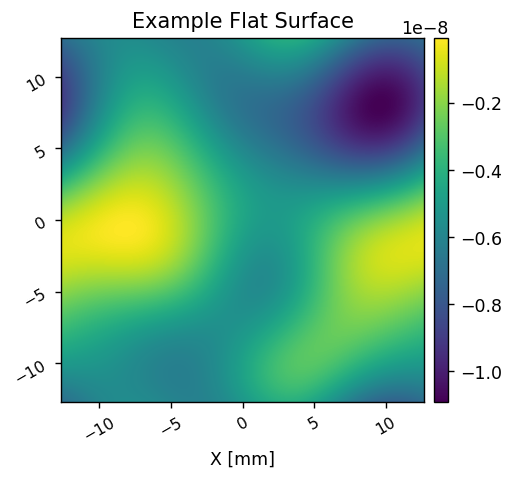

In [14]:
psd_list = [[3.284, 1180* u.nm**2/(u.m**(3.284-2)), 0.017*u.m, 0.0225, 0* u.nm**2 * u.m**2],
            [1.947, 0.02983* u.nm**2/(u.m**(1.947-2)), 15*u.m, 0.00335, 0* u.nm**2 * u.m**2],
            [2.827, 44.25* u.nm**2/(u.m**(2.827-2)), 0.00057*u.m, 0.000208, 1.27214e-14* u.nm**2 * u.m**2]]

seed = 123456

params = {
    'psd_parameters': psd_list, 
    'psd_weight': [1],
    'apply_reflection':True, 
    'incident_angle':15*u.degree, 
    'screen_size':int(npix*1), 
}

k_range = (np.arange(start=2.8, stop=30000, step=0.95)/u.m)
psd1 = psd_model(k_range, psd_list[0])
psd2 = psd_model(k_range, psd_list[1])
psd3 = psd_model(k_range, psd_list[2])

psd_tot = psd1 + psd2 + psd3

fig = plt.figure(figsize=[8,5], dpi=100)
plt.loglog(k_range.value, psd1.value, '--', label='psd 1',)
plt.loglog(k_range.value, psd2.value, '--', label='psd 2')
plt.loglog(k_range.value, psd3.value, '--', label='psd 3')
plt.loglog(k_range.value, psd_tot.value, label='total psd', linewidth=1.5)

# plt.vlines(max_sf.to_value(1/u.m), 1e-11, 1e-1, color='red')
plt.grid()
plt.ylim(top=0.1, bottom=1e-14)
plt.xlabel('Spatial Frequency [{0}]'.format(k_range.unit))
plt.ylabel('PSD [{0}]'.format(psd1.unit))
plt.title('Flat Mirror PSD')
plt.legend()
plt.close()
display(fig)

wfe = poppy.PowerSpectrumWFE(**params, seed=12, )
psd_opd = wfe.get_opd(wf)
psd_phasor = wfe.get_phasor(wf)
psd_trans = wfe.get_transmission(wf)

psd_opd = wfe.get_opd(wf)

imshow1(psd_opd, 'Example Flat Surface', pxscl=wf.pixelscale.to(u.mm/u.pix), xlabel='X [mm]', cmap='viridis')